In [1]:
import cdsapi
import os

new_download = False   

folder_out = 'cds_Data'

# create a client object
c = cdsapi.Client()

# define the request parameters
year = ['2023']
months = [str(i).zfill(2) for i in range(1, 13)] 
days = [str(i).zfill(2) for i in range(1, 32)]

#year = ['2023']
#months = [str(i).zfill(2) for i in range(1, 4)] 

variables_list = ['2m_temperature',
                '10m_u_component_of_wind', 
                '10m_v_component_of_wind',
                '100m_u_component_of_wind', 
                '100m_v_component_of_wind',
                'forecast_surface_roughness',
                'surface_pressure']

# define the output file name by year day and month 
downloaded_file = 'ERA5-Reanalysis_' + year[0] + months[0] + days[0] +'_till_' + year[0] + months[-1] + days[-1] + '_winds_germany.nc'
downloaded_file = os.path.join(folder_out, downloaded_file)

if new_download == True:
    # send the request to the CDS server
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'year': year,
            'month': months,
            'day': days,
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',],
            'variable': variables_list,
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'area': '47.270111/5.866315/55.099161/15.041931', # extract data for germany
            #'area': point, # extract data for a single point
            #'LEVELIST': '10/25/50/75/100', # specify the desired levels in meters
        },
        downloaded_file
    )

In [3]:
import plotly.graph_objects as go
import xarray as xr
import netCDF4 as nc
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.interpolate import griddata
from windpowerlib import ModelChain, WindTurbine, create_power_curve
from windpowerlib import data as wt
import logging
logging.getLogger().setLevel(logging.CRITICAL)


/Users/matthiasreif/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
#get names of wind turbines for which power curves and/or are provided
# set print_out=True to see the list of all available wind turbines
df = wt.get_turbine_types(print_out=False)

# find all Enercons
print(df[df["manufacturer"].str.contains("Enerc")])
#specification of wind turbine where power curve is provided in the 
#oedb turbine library

   manufacturer turbine_type  has_power_curve  has_cp_curve
1       Enercon   E-101/3050             True          True
2       Enercon   E-101/3500             True          True
3       Enercon   E-115/3000             True          True
4       Enercon   E-115/3200             True          True
5       Enercon   E-126/4200             True          True
6       Enercon   E-126/7500             True         False
7       Enercon   E-126/7580             True         False
8       Enercon   E-141/4200             True          True
9       Enercon     E-53/800             True          True
10      Enercon    E-70/2000             True         False
11      Enercon    E-70/2300             True          True
12      Enercon    E-82/2000             True          True
13      Enercon    E-82/2300             True          True
14      Enercon    E-82/2350             True          True
15      Enercon    E-82/3000             True          True
16      Enercon    E-92/2350            

In [4]:

############################## Basic Settings ############################ 
# Dunetal
# hubheight = 160
# turb_type = 'E-141/4200' # if there is no type, use the scale_turbine_to parameter to scale the turbine to a specific power
# max_power = 4200

# ??
# hubheight = 149
# turb_type = 'E-115/3000' # if there is no type, use the scale_turbine_to parameter to scale the turbine to a specific power
# max_power = 3000

# Dinkelacker
# hubheight = 63
# turb_type = 'E48/800' # if there is no type, use the scale_turbine_to parameter to scale the turbine to a specific power
# max_power = 600
# scale_turbine_to = 500

# Schoenemoor
# lat = 53.113911
# lon = 8.589094  
hubheight = 127.5 
turb_type = 'SWT113/3200' # if there is no type, use the scale_turbine_to parameter to scale the turbine to a specific power
max_power = 3200

# read the downloaded file
data = nc.Dataset(downloaded_file, 'r')

# extract the u and v wind components
longitude = data.variables['longitude'][:]
latitude = data.variables['latitude'][:]
time = data.variables['time'][:]
## convert time to list of datetime objects
dates = []
for t in time:
    date = datetime.datetime(1900, 1, 1) + datetime.timedelta(hours=int(t))
    dates.append(date)

#for loop over the lat or choose one lat here (how to interpolate?)
t2m_all = data.variables['t2m'][:]
u10_all = data.variables['u10'][:] 
v10_all = data.variables['v10'][:] 
u100_all = data.variables['u100'][:] 
v100_all = data.variables['v100'][:] 
fsr_all = data.variables['fsr'][:]
sp_all = data.variables['sp'][:]

# Create an empty 3D array to store the wind power data
power_data = np.empty((len(time),len(latitude),len(longitude)))

# close the file
data.close()

# Loop over latitude and longitude coordinates
for i in range(len(latitude)):
    for j in range(len(longitude)):
        # print(i,j)
        t2m_single = t2m_all[:,i,j]
        u10_single = u10_all[:,i,j]
        v10_single = v10_all[:,i,j]
        u100_single = u100_all[:,i,j]
        v100_single = v100_all[:,i,j]
        fsr_single = fsr_all[:,i,j]
        sp_single = sp_all[:,i,j]

        # get absolute wind speed
        wind_speed_10m = (u10_single**2 + v10_single**2)**0.5
        wind_speed_100m = (u100_single**2 + v100_single**2)**0.5

        # create a dictionary with the variables
        data_dict = {'wind_speed_10m': wind_speed_10m.flatten(), 
                    'wind_speed_100m': wind_speed_100m.flatten(),
                    'fsr': fsr_single.flatten(),
                    't2m': t2m_single.flatten(),
                    'sp': sp_single.flatten()
                    }

        # create a pandas DataFrame with the dictionary
        df_weather = pd.DataFrame(data_dict, index=dates)
        # create the MultiIndex columns
        col_dict = {('wind_speed', 10): ('wind_speed_10m', 'wind_speed'),
                    ('wind_speed', 100): ('wind_speed_100m', 'wind_speed'),
                    ('roughness_length', 0): ('fsr', 'roughness_length'),
                    ('temperature', 2): ('t2m', '2mtemperature'),
                    ('pressure', 0): ('sp', 'pressure')}
        df_weather.columns = pd.MultiIndex.from_tuples(col_dict.keys(), names=['variable_name', 'height'])
        df_weather = df_weather.rename(columns=col_dict)
        df_weather.index = pd.to_datetime(df_weather.index).tz_localize('UTC').tz_convert('Europe/Berlin')
        
        windpowerlib_turbine = {
                "nominal_power": max_power*1000,  # in W
                'turbine_type': turb_type,  # turbine type as in oedb turbine library
                'hub_height': hubheight  # in m
            }
        # initialize WindTurbine object
        wpl_turbine = WindTurbine(**windpowerlib_turbine)

        #create_power_curve(wind_speed=x_values, power=y_values*1000
        #  )
        #scale_turbine_to = None
        # to the given value
        #if scale_turbine_to is not None:
        #    wpl_turbine.power_curve['value'] =  wpl_turbine.power_curve['value']* scale_turbine_to*1000/max(wpl_turbine.power_curve['value'])
            

        # own specifications for ModelChain setup
        modelchain_data = {
            'wind_speed_model': 'logarithmic',      # 'logarithmic' (default),
                                                    # 'hellman' or
                                                    # 'interpolation_extrapolation'
            'density_model': 'barometric',           # 'barometric' (default), 'ideal_gas'
                                                    #  or 'interpolation_extrapolation'
            'temperature_model': 'linear_gradient', # 'linear_gradient' (def.) or
                                                    # 'interpolation_extrapolation'
            'power_output_model':
                'power_curve',                      # 'power_curve' (default) or
                                                    # 'power_coefficient_curve'
            'density_correction': False,             # False (default) or True
            'obstacle_height': 0,                   # default: 0
            'hellman_exp': None}                    # None (default) or None

        # initialize ModelChain with own specifications and use run_model method to
        # calculate power output
        mc_wpl_turbine = ModelChain(wpl_turbine, **modelchain_data).run_model(
            df_weather)
        # write power output time series to WindTurbine object
        wpl_turbine.power_output = mc_wpl_turbine.power_output

        # Get the wind power data for the current coordinate pair
        power_output_kW = wpl_turbine.power_output/1000  # Assuming this is the wind power data
        
        # Save the wind power data to the corresponding position in the 3D array
        power_data[:,i, j] = power_output_kW

#delete the 1h value of the following year, which is caused by utc vs. cet: 
df_weather = df_weather[:-1]
power_data = power_data[:-1]

In [5]:
import pandas as pd
import pytz

# Specify the path to the CSV file
csv_file = 'spot_prices/Gro_handelspreise_'+year[0]+'01010000_'+year[0]+'12312359_Stunde_plus_Marktwert.csv'

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(csv_file, delimiter=';')

# Extract the columns of interest (time and Deutschland/Luxemburg prices)
date = data[data.columns[0]]
time = data[data.columns[1]]

prices_de_lu = data[data.columns[3]]
marktwert = data[data.columns[4]]

# Clean and convert prices to numeric values
prices_de_lu = prices_de_lu.str.replace(',', '.').astype(float)
marktwert = marktwert.str.replace(',', '.').astype(float)

# Combine 'Datum' and 'Anfang' columns as strings
datetime_strings = date + ' ' + time

# Create a new DataFrame with the combined datetime strings and prices
prices = pd.DataFrame({'Time': datetime_strings, 'Prices_DE_LU': prices_de_lu, 'Marktwert': marktwert})

# Convert the 'Time' column to datetime objects
prices['Time'] = pd.to_datetime(prices['Time'], format='%d.%m.%Y %H:%M')

# Set the 'Time' column as the index
prices.set_index('Time', inplace=True)

# Set the timezone to Europe, handling ambiguous times as 'infer'
prices = prices.tz_localize(pytz.timezone('Europe/Brussels'), ambiguous='infer')

#suit prices to the weather data and delete the first hour of the year
prices = prices.iloc[1:]

# Print the DataFrame for verification
# print(prices)


In [6]:
import numpy as np

# Calculate the average of prices
prices_average = prices['Prices_DE_LU'].mean()

# Create an empty array to store the result
base_parity_ratio_array = np.empty(power_data.shape)
price_advantage_array = np.empty(power_data.shape)

# Loop over each timestep in power_data
for i in range(power_data.shape[0]):
    base_parity_ratio_array[i] = power_data[i] * prices['Prices_DE_LU'].values[i] 
    price_advantage_array[i] = (prices['Prices_DE_LU'].values[i]-prices['Marktwert'].values[i]) * power_data[i] / 1000


base_parity_ratio = base_parity_ratio_array.sum(0)/power_data.sum(0) / prices_average * 100 # *100 to get in %
price_advantage = price_advantage_array.sum(0)

# Verify the shape of the result
# print(price_advantage)


In [7]:
base_parity_ratio

array([[86.33088422, 86.30666218, 86.22420048, ..., 85.77664474,
        86.19619624, 86.49288767],
       [85.91254737, 85.89854334, 85.84806052, ..., 85.75342417,
        86.01511114, 86.28346211],
       [85.61837267, 85.64931151, 85.62122369, ..., 85.55575387,
        85.87140905, 86.04446088],
       ...,
       [80.3887887 , 79.54180137, 79.00712277, ..., 68.61472091,
        70.56482857, 72.6848848 ],
       [81.06441079, 79.6588437 , 79.33861464, ..., 71.50547725,
        74.51260134, 76.17151179],
       [80.26972936, 79.47570422, 78.77804541, ..., 77.67396536,
        77.84242489, 78.5377783 ]])

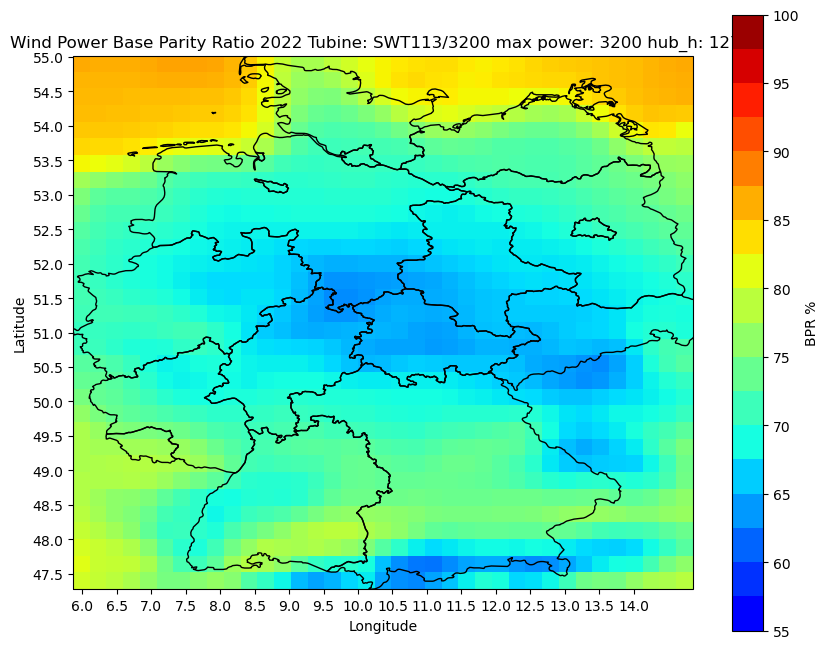

'wind_power_BPR_2022_tubine_SWT113_3200_max_pow_3200_hub_h_127.5.html'

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Create a figure and axis with PlateCarree projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

# Set the desired latitude and longitude range for the map
lon_min, lon_max = int(min(longitude))-0.5, int(max(longitude))+0.5
lat_min, lat_max = int(min(latitude))-0.5, int(max(latitude))+0.5

# Set the gridline locations to match the x and y ticks
xticks = np.arange(lon_min, lon_max, 0.5)
yticks = np.arange(lat_min, lat_max, 0.5)

# Add the gridlines
ax.gridlines(xlocs=xticks, ylocs=yticks, linestyle='--', linewidth=0.5, color='gray')

ax.set_xticks(xticks)
ax.set_yticks(yticks)

# Customize the plot
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title("Wind Power Base Parity Ratio "+year[0]+" Tubine: "+turb_type.split('/')[0]+"/"+turb_type.split('/')[1]+" max power: "+str(max_power)+" hub_h: "+str(hubheight) )

# Format the tick labels with the desired precision
ax.xaxis.set_major_formatter('{:.1f}'.format)
ax.yaxis.set_major_formatter('{:.1f}'.format)

# Plot the power data on a map using imshow
im = ax.imshow(base_parity_ratio, cmap='jet', extent=(min(longitude), max(longitude), min(latitude), max(latitude)), vmin=50, vmax=100)

# Customize the colorbar
plt.colorbar(im, ax=ax, label='BPR %', boundaries=[x / 10 for x in range(550, 1001, 25)])

# Add the borders of Germany's Bundesländer
# Load the shapefile data for Germany's Bundesländer
shapefile_path = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
reader = shpreader.Reader(shapefile_path)
germany_b = reader.records()
# Find the record corresponding to Germany
germany_b_record = None
for record in germany_b:
    if record.attributes['iso_a2'] == 'DE':
        germany_b_record = record
        ax.add_geometries([germany_b_record.geometry], ccrs.Mercator(), facecolor='none', edgecolor='black')


# Save the plot to an image file
plt.savefig("wind_power_BPR_"+year[0]+"_tubine_"+turb_type.split('/')[0]+"_"+turb_type.split('/')[1]+"_max_pow_"+str(max_power)+"_hub_h_"+str(hubheight)+".png")

# Show the plot
plt.show()

import plotly.graph_objects as go
from plotly.offline import plot

# Create a grid of latitude and longitude values
lon_values = np.arange(lon_min, lon_max, 0.5)
lat_values = np.arange(lat_min, lat_max, 0.5)

# Create a heatmap trace
heatmap = go.Heatmap(
    z=base_parity_ratio,
    x=longitude,
    y=latitude,
    colorscale='Jet',
    zmin=50,
    zmax=100,
    hovertemplate='Longitude: %{x:.2f}<br>Latitude: %{y:.2f}<br>BPR: %{z:.1f} %<extra></extra>'
)

# Create a scatter trace for gridlines
gridlines = go.Scatter(
    x=np.repeat(lon_values, len(lat_values)),
    y=np.tile(lat_values, len(lon_values)),
    mode='markers',
    marker=dict(size=1, color='black'),
    hoverinfo='skip'
)

# Create a figure and add the traces
fig = go.Figure(data=[heatmap, gridlines])

# Configure the layout
fig.update_layout(
    title="Wind Power Base Parity Ratio "+year[0]+" Tubine: "+turb_type.split('/')[0]+"/"+turb_type.split('/')[1]+" max power: "+str(max_power)+" hub_h: "+str(hubheight) ,
    xaxis=dict(
        title='Longitude',
        tickmode='array',
        tickvals=lon_values,
        ticktext=[f'{val:.2f}' for val in lon_values]
    ),
    yaxis=dict(
        title='Latitude',
        tickmode='array',
        tickvals=lat_values,
        ticktext=[f'{val:.2f}' for val in lat_values]
    ),
    coloraxis_colorbar=dict(title='BPR %', titleside='right'),
)

# Show the interactive plot
fig.show()

# 
# Save the plot as an HTML file
plot(fig, filename="wind_power_BPR_"+year[0]+"_tubine_"+turb_type.split('/')[0]+"_"+turb_type.split('/')[1]+"_max_pow_"+str(max_power)+"_hub_h_"+str(hubheight)+".html")



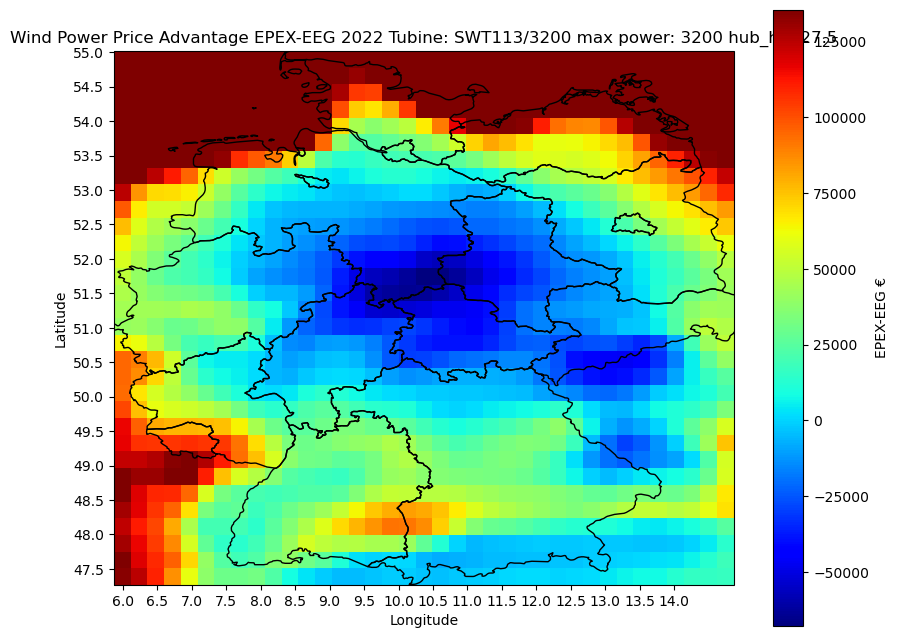

'wind_power_price_advantage_2022_tubine_SWT113_3200_max_pow_3200_hub_h_127.5.html'

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Create a figure and axis with PlateCarree projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

# Set the desired latitude and longitude range for the map
lon_min, lon_max = int(min(longitude))-0.5, int(max(longitude))+0.5
lat_min, lat_max = int(min(latitude))-0.5, int(max(latitude))+0.5

# Set the gridline locations to match the x and y ticks
xticks = np.arange(lon_min, lon_max, 0.5)
yticks = np.arange(lat_min, lat_max, 0.5)

# Add the gridlines
ax.gridlines(xlocs=xticks, ylocs=yticks, linestyle='--', linewidth=0.5, color='gray')

ax.set_xticks(xticks)
ax.set_yticks(yticks)

# Customize the plot
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title("Wind Power Price Advantage EPEX-EEG "+year[0]+" Tubine: "+turb_type.split('/')[0]+"/"+turb_type.split('/')[1]+" max power: "+str(max_power)+" hub_h: "+str(hubheight) )

# Format the tick labels with the desired precision
ax.xaxis.set_major_formatter('{:.1f}'.format)
ax.yaxis.set_major_formatter('{:.1f}'.format)

vmin = price_advantage.min()
vmax = -price_advantage.min()*2

# Plot the power data on a map using imshow
im = ax.imshow(price_advantage, cmap='jet', extent=(min(longitude), max(longitude), min(latitude), max(latitude)), vmin=vmin, vmax=vmax)

# Customize the colorbar
plt.colorbar(im, ax=ax, label='EPEX-EEG €')

# Add the borders of Germany's Bundesländer
# Load the shapefile data for Germany's Bundesländer
shapefile_path = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
reader = shpreader.Reader(shapefile_path)
germany_b = reader.records()
# Find the record corresponding to Germany
germany_b_record = None
for record in germany_b:
    if record.attributes['iso_a2'] == 'DE':
        germany_b_record = record
        ax.add_geometries([germany_b_record.geometry], ccrs.Mercator(), facecolor='none', edgecolor='black')


# Save the plot to an image file
plt.savefig("wind_power_price_advantage_"+year[0]+"_tubine_"+turb_type.split('/')[0]+"_"+turb_type.split('/')[1]+"_max_pow_"+str(max_power)+"_hub_h_"+str(hubheight)+".png")


# Show the plot
plt.show()

import plotly.graph_objects as go
from plotly.offline import plot

# Create a grid of latitude and longitude values
lon_values = np.arange(lon_min, lon_max, 0.5)
lat_values = np.arange(lat_min, lat_max, 0.5)

# Create a heatmap trace
heatmap = go.Heatmap(
    z=price_advantage,
    x=longitude,
    y=latitude,
    colorscale='Jet',
    zmin=price_advantage.min(),
    zmax=-price_advantage.min()*1.5,
    hovertemplate='Longitude: %{x:.2f}<br>Latitude: %{y:.2f}<br>EPEX-EEG: %{z:.1f} €<extra></extra>'
)

# Create a scatter trace for gridlines
gridlines = go.Scatter(
    x=np.repeat(lon_values, len(lat_values)),
    y=np.tile(lat_values, len(lon_values)),
    mode='markers',
    marker=dict(size=1, color='black'),
    hoverinfo='skip'
)

# Create a figure and add the traces
fig = go.Figure(data=[heatmap, gridlines])

# Configure the layout
fig.update_layout(
    title="Wind Power Price Advantage EPEX-EEG "+year[0]+" Tubine: "+turb_type.split('/')[0]+"/"+turb_type.split('/')[1]+" max power: "+str(max_power)+" hub_h: "+str(hubheight) ,
    xaxis=dict(
        title='Longitude',
        tickmode='array',
        tickvals=lon_values,
        ticktext=[f'{val:.2f}' for val in lon_values]
    ),
    yaxis=dict(
        title='Latitude',
        tickmode='array',
        tickvals=lat_values,
        ticktext=[f'{val:.2f}' for val in lat_values]
    ),
    coloraxis_colorbar=dict(title='EPEX-EEG €', titleside='right'),
)

# Show the interactive plot
fig.show()

# 
# Save the plot as an HTML file
plot(fig, filename="wind_power_price_advantage_"+year[0]+"_tubine_"+turb_type.split('/')[0]+"_"+turb_type.split('/')[1]+"_max_pow_"+str(max_power)+"_hub_h_"+str(hubheight)+".html")


In [10]:
########### code to interpolate on a certain Gridpoint, takes abouot 30min

# # specify the target coordinate
# target_latitude = lat
# target_longitude = lon

# # create empty lists to store interpolated values
# t2m_interp = []
# u10_interp = []
# v10_interp = []
# u100_interp = []
# v100_interp = []
# fsr_interp = []
# sp_interp = []

# # Create mesh grid of longitude and latitude
# lon_mesh, lat_mesh = np.meshgrid(longitude, latitude)

# # Loop over time
# for t in range(len(time)):
#     # Interpolate the values to the target coordinate at each time step
#     t2m = griddata((lon_mesh.flatten(), lat_mesh.flatten()), t2m_all[t,:,:].flatten(), (target_longitude, target_latitude), method='linear')
#     u10 = griddata((lon_mesh.flatten(), lat_mesh.flatten()), u10_all[t,:,:].flatten(), (target_longitude, target_latitude), method='linear')
#     v10 = griddata((lon_mesh.flatten(), lat_mesh.flatten()), v10_all[t,:,:].flatten(), (target_longitude, target_latitude), method='linear')
#     u100 = griddata((lon_mesh.flatten(), lat_mesh.flatten()), u100_all[t,:,:].flatten(), (target_longitude, target_latitude), method='linear')
#     v100 = griddata((lon_mesh.flatten(), lat_mesh.flatten()), v100_all[t,:,:].flatten(), (target_longitude, target_latitude), method='linear')
#     fsr = griddata((lon_mesh.flatten(), lat_mesh.flatten()), fsr_all[t,:,:].flatten(), (target_longitude, target_latitude), method='linear')
#     sp = griddata((lon_mesh.flatten(), lat_mesh.flatten()), sp_all[t,:,:].flatten(), (target_longitude, target_latitude), method='linear')


#     # append the interpolated values to the lists
#     t2m_interp.append(t2m)
#     u10_interp.append(u10)
#     v10_interp.append(v10)
#     u100_interp.append(u100)
#     v100_interp.append(v100)
#     fsr_interp.append(fsr)
#     sp_interp.append(sp)
#     print(t)
